In [75]:
import pandas as pd

silent_codes_path = './data/silent_speech_codes.csv'
silent_volts_path = './data/silent_speech_volts.csv'
silent_labels_path = './data/silent_speech_labels.csv'

voiced_codes_path = './data/voiced_speech_codes.csv'
voiced_volts_path = './data/voiced_speech_volts.csv'
voiced_labels_path = './data/voiced_speech_labels.csv'

# Load voiced dataframes
voiced_codes_df = pd.read_csv(voiced_codes_path).iloc[:, :6]    # Only take the first 6 columns
voiced_volts_df = pd.read_csv(voiced_volts_path).iloc[:, :6]    # Only take the first 6 columns
voiced_labels_df = pd.read_csv(voiced_labels_path, header=None)
print(len(voiced_labels_df))

# Load silent dataframes
silent_codes_df = pd.read_csv(silent_codes_path).iloc[:, :6]    # Only take the first 6 columns
silent_volts_df = pd.read_csv(silent_volts_path).iloc[:, :6]    # Only take the first 6 columns
silent_labels_df = pd.read_csv(silent_labels_path, header=None)
print(len(silent_labels_df))

def display_heads(voiced_codes_df, voiced_volts_df, silent_codes_df, silent_volts_df):
    voiced_codes_head = voiced_codes_df.head()
    voiced_volts_head = voiced_volts_df.head()
    silent_codes_head = silent_codes_df.head()
    silent_volts_head = silent_volts_df.head()
    print(voiced_codes_head, voiced_volts_head, silent_codes_head, silent_volts_head)

# display_heads(voiced_codes_df, voiced_volts_df, silent_codes_df, silent_volts_df)

99
100


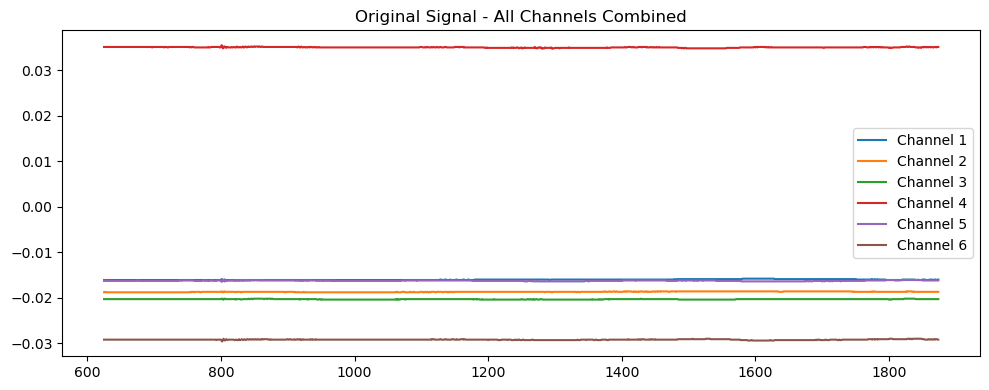

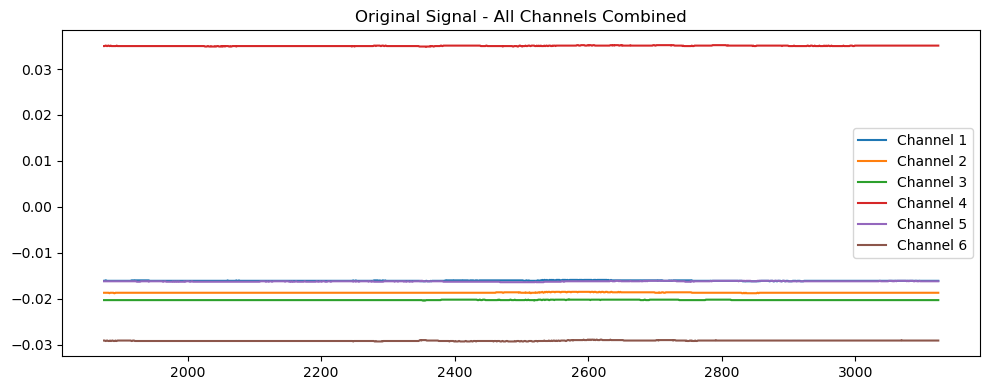

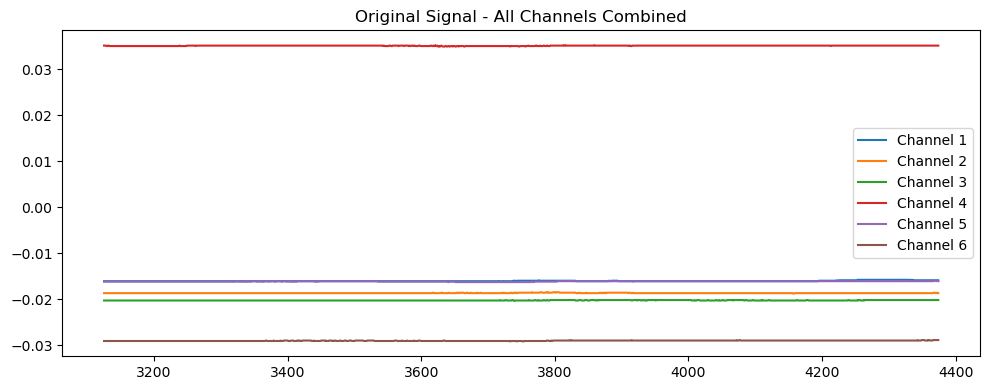

In [76]:
import matplotlib.pyplot as plt
import numpy as np

def plot_original_signal_combined(df, start_sample=625, end_sample=1875):
    """
    Plots all channels of the original signal in one plot for a specified sample range.
    """
    fig, ax = plt.subplots(figsize=(10, 4))
    num_channels = df.shape[1]
    for channel in range(num_channels):
        ax.plot(df.iloc[start_sample:end_sample, channel], label=f'Channel {channel+1}')
    ax.set_title('Original Signal - All Channels Combined')
    ax.legend()
    plt.tight_layout()
    plt.show()

# Example usage
# Note: Before using plot_signal_chunks_combined, ensure your chunks are correctly formatted
# as a list of 2D numpy arrays, where each array represents a chunk with shape (chunk_size, num_channels).

plot_original_signal_combined(voiced_volts_df, 625, 1875)
plot_original_signal_combined(voiced_volts_df, 1875, 3125)
plot_original_signal_combined(voiced_volts_df, 3125, 4375)

In [77]:
from scipy.signal import butter, filtfilt, iirnotch

def butter_bandpass(lowcut, highcut, fs, order=4):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=4):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = filtfilt(b, a, data)
    return y

def apply_notch_filter(data, notch_freq, fs, quality_factor=30):
    b, a = iirnotch(notch_freq / (0.5 * fs), quality_factor)
    y = filtfilt(b, a, data)
    return y

# Parameters for the filters
fs = 250  # Sampling rate in Hz
lowcut = 1.3  # Low cut frequency in Hz
highcut = 50  # High cut frequency in Hz, adjusted for movement artifact avoidance
notch_freq = 60  # Notch frequency for power line noise in Hz

# Apply the Butterworth bandpass filter
for column in voiced_volts_df.columns:
    voiced_volts_df[column] = butter_bandpass_filter(voiced_volts_df[column].values, lowcut, highcut, fs, order=4)

# Apply the notch filter
for column in voiced_volts_df.columns:
    voiced_volts_df[column] = apply_notch_filter(voiced_volts_df[column].values, notch_freq, fs)

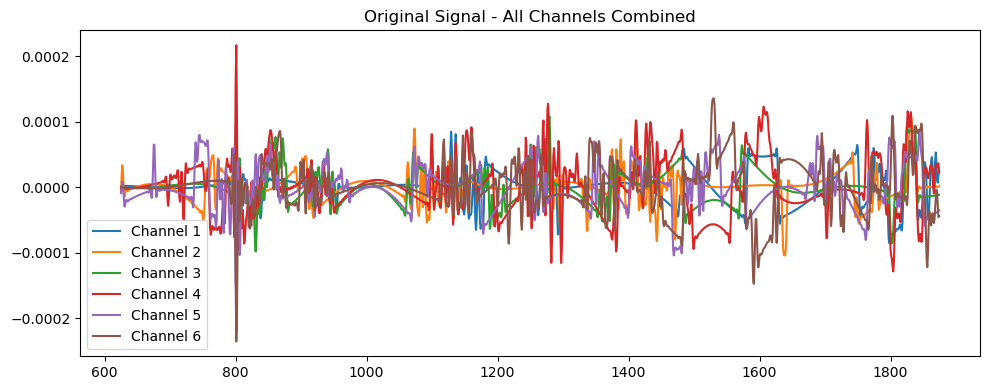

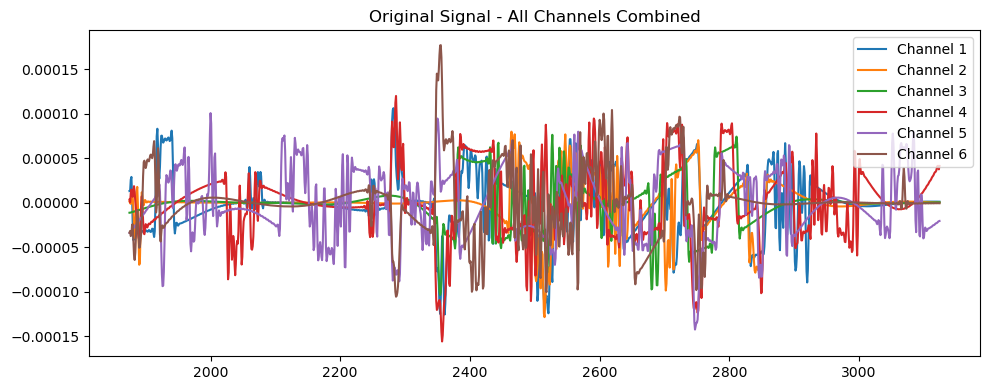

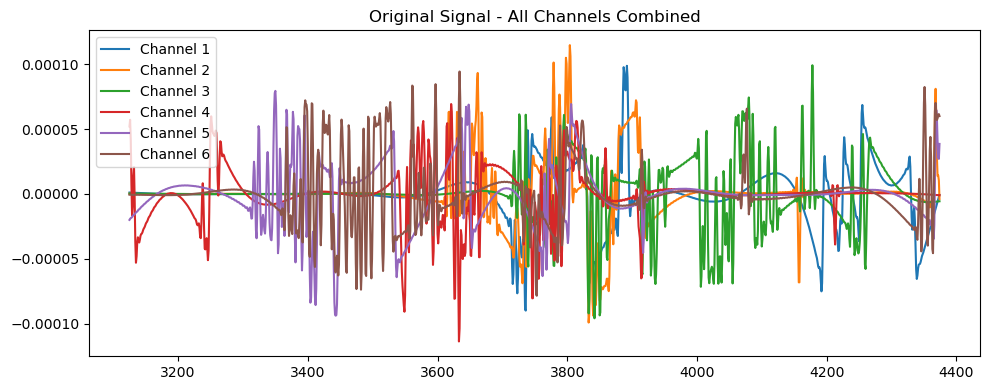

In [78]:
import matplotlib.pyplot as plt
import numpy as np

def plot_original_signal_combined(df, start_sample=625, end_sample=1875):
    """
    Plots all channels of the original signal in one plot for a specified sample range.
    """
    fig, ax = plt.subplots(figsize=(10, 4))
    num_channels = df.shape[1]
    for channel in range(num_channels):
        ax.plot(df.iloc[start_sample:end_sample, channel], label=f'Channel {channel+1}')
    ax.set_title('Original Signal - All Channels Combined')
    ax.legend()
    plt.tight_layout()
    plt.show()

# Example usage
# Note: Before using plot_signal_chunks_combined, ensure your chunks are correctly formatted
# as a list of 2D numpy arrays, where each array represents a chunk with shape (chunk_size, num_channels).

plot_original_signal_combined(voiced_volts_df, 625, 1875)
plot_original_signal_combined(voiced_volts_df, 1875, 3125)
plot_original_signal_combined(voiced_volts_df, 3125, 4375)

In [79]:
import numpy as np
import pandas as pd

# Assuming voiced_labels_df is loaded and contains binary labels ('yes'/'no' converted to 1/0)
voiced_binary_labels = voiced_labels_df.iloc[:, 0].map({'yes': 1, 'no': 0}).tolist()
print(f"Total number of labels: {len(voiced_binary_labels)}")

# Function to chunk the multichannel voltage signals into 5-second chunks with a 2.5 second offset
def chunk_signals_from_offset_multichannel(df, chunk_size=1250, offset=625):
    chunks = []
    # Calculate the number of rows to skip at the start based on the offset
    start_index = offset
    # Calculate the number of chunks possible with the given offset and chunk size
    for i in range(start_index, len(df), chunk_size):
        # Ensure the chunk does not exceed the dataframe's length
        if i + chunk_size <= len(df):
            chunk = df.iloc[i:i + chunk_size].values  # This keeps the chunk in a multichannel format
            chunks.append(chunk)
    return chunks

# Use the adjusted chunking function for multichannel data
voiced_volts_chunks = chunk_signals_from_offset_multichannel(voiced_volts_df)
print(f"Total number of chunks before aligning: {len(voiced_volts_chunks)}")

# Since each chunk now is a 2D array (1250x8), we need to adjust how we align and handle these with labels.
# Align the chunks with the binary labels
min_length = min(len(voiced_volts_chunks), len(voiced_binary_labels))
voiced_volts_chunks_aligned = voiced_volts_chunks[:min_length]
voiced_binary_labels_aligned = voiced_binary_labels[:min_length]

Total number of labels: 99
Total number of chunks before aligning: 103


In [80]:
# Print lengths to verify alignment
print(f'Number of aligned chunks: {len(voiced_volts_chunks_aligned)}')
print(f'Number of aligned labels: {len(voiced_binary_labels_aligned)}')

# Verify that the lengths match
if len(voiced_volts_chunks_aligned) == len(voiced_binary_labels_aligned):
    print("The number of chunks and labels are correctly aligned.")
else:
    print("Mismatch in the number of chunks and labels.")

# Inspect first aligned chunk
if voiced_volts_chunks_aligned:  # Check if there's at least one chunk
    example_chunk = np.array(voiced_volts_chunks_aligned[0])
    # Append the binary label to the last column of the chunk
    label_for_chunk = voiced_binary_labels_aligned[0]
    print(f"Example chunk shape (before label): {example_chunk.shape}")
    print(f"Label for example chunk: {label_for_chunk}")
else:
    print("No chunks available for demonstration.")

Number of aligned chunks: 99
Number of aligned labels: 99
The number of chunks and labels are correctly aligned.
Example chunk shape (before label): (1250, 6)
Label for example chunk: 1


In [81]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

# Flatten each chunk for use in a fully connected neural network
X = np.array([chunk.flatten() for chunk in voiced_volts_chunks_aligned])
y = np.array(voiced_binary_labels_aligned)

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert data to torch tensors
X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.FloatTensor(y_train).unsqueeze(1)  # add an extra dimension to y
X_test_tensor = torch.FloatTensor(X_test)
y_test_tensor = torch.FloatTensor(y_test).unsqueeze(1)  # add an extra dimension to y

# Create tensor datasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Create data loaders
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)

In [82]:
# Build the neural net
class SimpleFNN(nn.Module):
    def __init__(self, input_size):
        super(SimpleFNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        return x

# Model initialization
input_size = X_train.shape[1]  # Number of features
model = SimpleFNN(input_size)

# Loss and optimizer
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training the model
num_epochs = 20
for epoch in range(num_epochs):
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}')

# Evaluating the model
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for inputs, labels in test_loader:
        outputs = model(inputs)
        predicted = outputs.round()  # Using 0.5 as the threshold
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f'Accuracy: {accuracy}%')

Epoch 1/20, Loss: 0.7063866257667542
Epoch 2/20, Loss: 0.7044246792793274
Epoch 3/20, Loss: 0.7062162160873413
Epoch 4/20, Loss: 0.6918790340423584
Epoch 5/20, Loss: 0.6897050738334656
Epoch 6/20, Loss: 0.6922428011894226
Epoch 7/20, Loss: 0.6880607604980469
Epoch 8/20, Loss: 0.6937416195869446
Epoch 9/20, Loss: 0.6944850087165833
Epoch 10/20, Loss: 0.6933249235153198
Epoch 11/20, Loss: 0.6930130124092102
Epoch 12/20, Loss: 0.6919129490852356
Epoch 13/20, Loss: 0.6908711791038513
Epoch 14/20, Loss: 0.6893187165260315
Epoch 15/20, Loss: 0.6919082403182983
Epoch 16/20, Loss: 0.6887058019638062
Epoch 17/20, Loss: 0.6914416551589966
Epoch 18/20, Loss: 0.6820301413536072
Epoch 19/20, Loss: 0.6965068578720093
Epoch 20/20, Loss: 0.6843147277832031
Accuracy: 30.0%


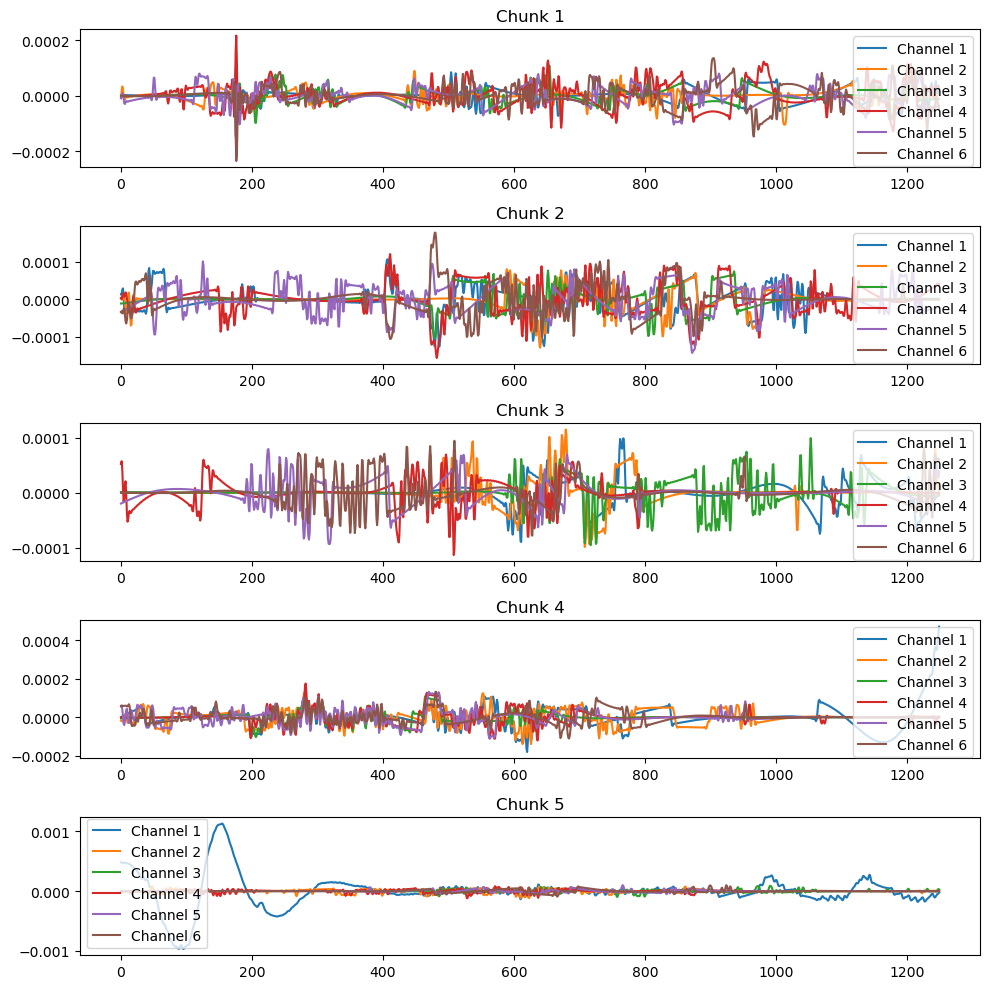

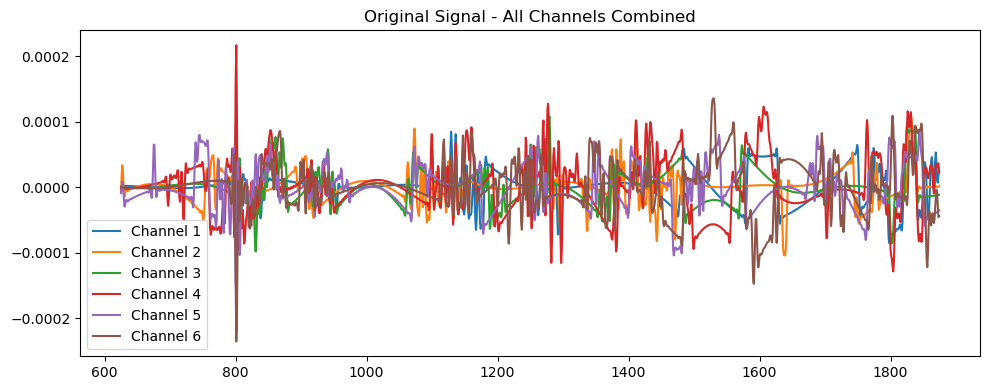

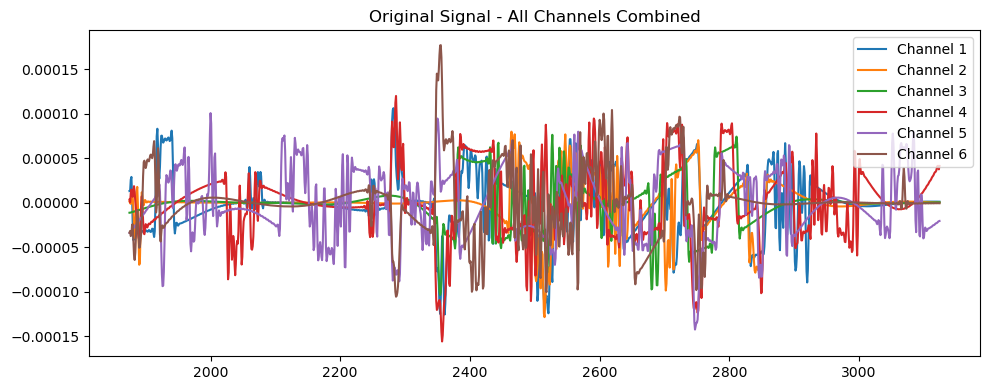

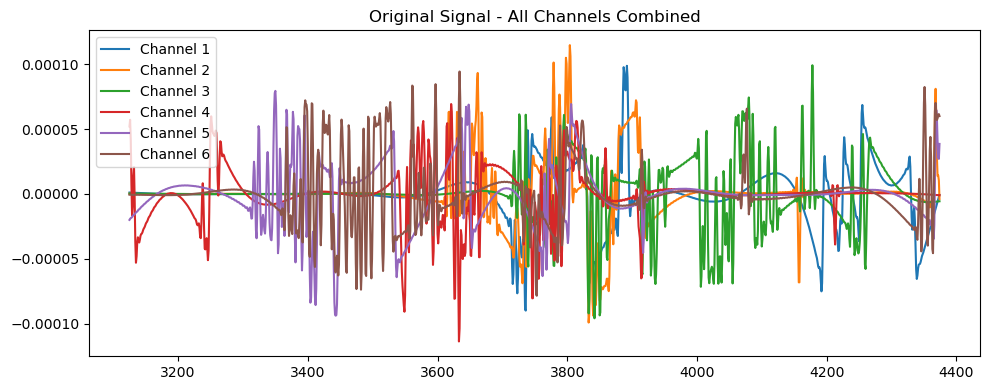

In [72]:
import matplotlib.pyplot as plt
import numpy as np

def plot_signal_chunks_combined(chunks, num_chunks=5):
    """
    Plots combined channels for each signal chunk.
    """
    fig, axs = plt.subplots(num_chunks, 1, figsize=(10, 2 * num_chunks), squeeze=False)
    for i, chunk in enumerate(chunks[:num_chunks]):
        for channel in range(chunk.shape[1]):
            axs[i, 0].plot(chunk[:, channel], label=f'Channel {channel+1}')
        axs[i, 0].set_title(f'Chunk {i+1}')
        axs[i, 0].legend()
    plt.tight_layout()
    plt.show()

def plot_original_signal_combined(df, start_sample=625, end_sample=1875):
    """
    Plots all channels of the original signal in one plot for a specified sample range.
    """
    fig, ax = plt.subplots(figsize=(10, 4))
    num_channels = df.shape[1]
    for channel in range(num_channels):
        ax.plot(df.iloc[start_sample:end_sample, channel], label=f'Channel {channel+1}')
    ax.set_title('Original Signal - All Channels Combined')
    ax.legend()
    plt.tight_layout()
    plt.show()

# Example usage
# Note: Before using plot_signal_chunks_combined, ensure your chunks are correctly formatted
# as a list of 2D numpy arrays, where each array represents a chunk with shape (chunk_size, num_channels).

plot_signal_chunks_combined(voiced_volts_chunks, num_chunks=5)
plot_original_signal_combined(voiced_volts_df, 625, 1875)
plot_original_signal_combined(voiced_volts_df, 1875, 3125)
plot_original_signal_combined(voiced_volts_df, 3125, 4375)